<a href="https://colab.research.google.com/github/madisonherrmann/neural_network/blob/main/Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd /content/gdrive/MyDrive/Colab

/content/gdrive/MyDrive/Colab


In [ ]:
import numpy as np  #Provides numpy arrays and methods
import pandas as pd #Provides data frames
import seaborn as sns

#Tensorflow

import tensorflow as tf #Tensorflor and Keras libraries
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate   #Types of layers we will need
from tensorflow.keras.models import Model, load_model  #Functions to build and load models
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Accuracy, Precision, Recall, CategoricalAccuracy

#For visualization / analysis

import matplotlib.pyplot as plt #Plotting functions

#Below is for doing some analysis in Python

import scipy.cluster.hierarchy as shc #Python function for hierarchical clustering
from sklearn.manifold import MDS  #Python function for multidimensional scaling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight

In [ ]:
file_path = '/content/gdrive/MyDrive/Colab'
df = pd.read_csv('text_mood.csv')
df = df.iloc[:, 1:]

In [ ]:
print(df.head())

                                                text  label
0      i just feel really helpless and heavy hearted      4
1  ive enjoyed being able to slouch about relax a...      0
2  i gave up my internship with the dmrg and am f...      4
3                         i dont know i feel so lost      0
4  i am a kindergarten teacher and i am thoroughl...      4


In [ ]:
emotion_mapping = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}

df['emotion'] = df['label'].map(emotion_mapping)

print(df)

                                                     text  label   emotion
0           i just feel really helpless and heavy hearted      4      fear
1       ive enjoyed being able to slouch about relax a...      0   sadness
2       i gave up my internship with the dmrg and am f...      4      fear
3                              i dont know i feel so lost      0   sadness
4       i am a kindergarten teacher and i am thoroughl...      4      fear
...                                                   ...    ...       ...
416804  i feel like telling these horny devils to find...      2      love
416805  i began to realize that when i was feeling agi...      3     anger
416806  i feel very curious be why previous early dawn...      5  surprise
416807  i feel that becuase of the tyranical nature of...      3     anger
416808  i think that after i had spent some time inves...      5  surprise

[416809 rows x 3 columns]


In [ ]:
emotion_counts = df['emotion'].value_counts()

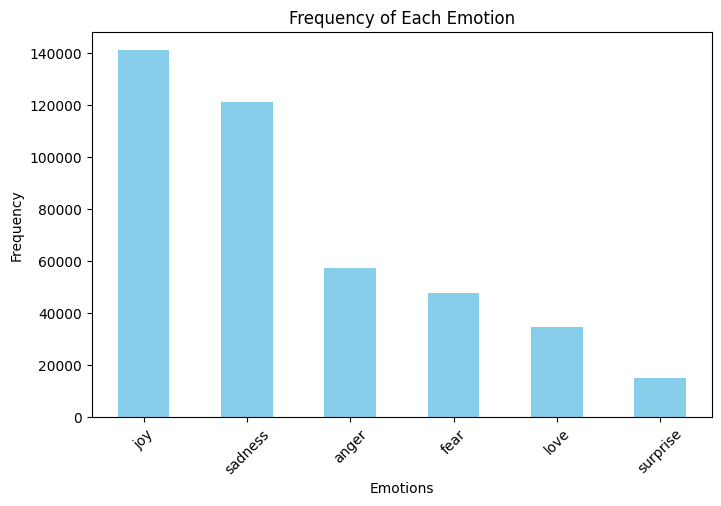

In [ ]:
# Create a bar plot
plt.figure(figsize=(8, 5))
emotion_counts.plot(kind='bar', color='skyblue')
plt.title('Emotion Frequency')
plt.xlabel('Emotions')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate the emotion labels for better readability
plt.show()

In [ ]:
print(df.dtypes)

text       object
label       int64
emotion    object
dtype: object


In [ ]:
path_to_file = '/content/gdrive/MyDrive/Colab/embeddings.npy'
embeddings = np.load(path_to_file)


In [ ]:
# Split data
xtrn, xtst, ytrn, ytst = train_test_split(embeddings, df['label'], test_size=0.1, random_state=42)

In [ ]:
print("Shape of train embeddings:", xtrn.shape)
print("Shape of test embeddings:", xtst.shape)
print("Sample labels:", ytrn[:50])
print("Sample labels:", ytst[:50])

Shape of train embeddings: (375128, 1536)
Shape of test embeddings: (41681, 1536)
Sample labels: 380657    1
363775    0
42951     2
99105     1
100297    4
239569    0
284571    1
226205    0
178898    0
202312    1
114295    2
258559    0
290851    0
183670    3
119329    2
160113    1
112722    1
6302      1
333483    1
222582    1
104429    0
172875    1
69083     1
412033    4
182517    0
187042    3
209937    1
288460    0
342892    0
401139    0
218262    1
416270    3
381817    4
335720    0
161907    0
133146    3
140660    1
331869    0
92873     1
191342    5
70951     0
332687    0
151096    4
157301    1
319304    4
153959    0
88102     1
19916     3
144109    3
276330    0
Name: label, dtype: int64
Sample labels: 36130     0
138065    0
146440    3
103337    0
315528    1
414303    2
407867    1
291389    1
227948    5
176638    0
369473    3
252952    0
365397    4
79012     1
5948      0
252161    2
314970    4
60923     0
187359    1
414256    5
53564     5
190309    

In [ ]:
ytrn = to_categorical(ytrn, num_classes=6)
ytst = to_categorical(ytst, num_classes=6)

In [ ]:
np.unique(ytrn)
np.unique(ytst)

array([0., 1.], dtype=float32)

In [ ]:

class_weights = {0: 1.,
                1: 1.,
                2: 4.,
                3: 2.,
                4: 3.,
                5: 10.}


In [ ]:
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.indices = np.arange(self.x.shape[0])

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        inds = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x = self.x[inds]
        batch_y = self.y[inds]
        return batch_x, batch_y


In [ ]:
nepochs = 10 #Number of training epochs
bsize = 32    #Batch size
lrate = .001 #Learning rate
lossfunction = 'categorical_crossentropy'
wtrange = 1.0  #Range for initial weight randomization

#Define parameters for initial random weights:
wt_init = tf.keras.initializers.RandomUniform(minval = -wtrange, maxval = wtrange, seed = 1111)

#Set parameters for the gradient descent method:
opt = tf.keras.optimizers.Adam(learning_rate=lrate)
input_shape = xtrn.shape[1]  # Feature size of embeddings
output_units = 6  # Corresponds to the number of emotions


# Build the model using the functional API
xin = Input(shape=(input_shape,), name='input_layer')
xhid1 = Dense(128, activation='relu', name='hidden_layer1',
              kernel_initializer=wt_init, bias_initializer=wt_init)(xin)
xdrop1 = Dropout(0.5)(xhid1)
xhid2 = Dense(64, activation='relu', name='hidden_layer2',
              kernel_initializer=wt_init, bias_initializer=wt_init)(xdrop1)
xdrop2 = Dropout(0.5)(xhid2)
xout = Dense(output_units, activation='softmax', name='output_layer',
             kernel_initializer=wt_init, bias_initializer=wt_init)(xdrop2)

# Create the model
model = Model(inputs=xin, outputs=xout, name='emotion_model')

# Print the model summary
model.compile(optimizer=opt, loss=lossfunction, metrics =[CategoricalAccuracy(name='accuracy')])
model.save_weights('ff_initial.h1')
# Model summary
model.summary()

 #Using the generator for training
train_generator = DataGenerator(xtrn, ytrn, batch_size=bsize)
val_generator = DataGenerator(xtst, ytst, batch_size=bsize)


# Train the model with class weights
H = model.fit(x=train_generator, epochs=nepochs, validation_data=val_generator, class_weight=class_weights)


Model: "emotion_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1536)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 128)               196736    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 hidden_layer2 (Dense)       (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 output_layer (Dense)        (None, 6)                 390       
                                                                 
Total params: 205382 (802.27 KB)
Trainable params: 20

In [ ]:
model.evaluate(x=xtst, y=ytst, batch_size = 100)

417/417 [==============================] - 1s 3ms/step - loss: 1.7927 - accuracy: 0.3028


[1.792696475982666, 0.30282384157180786]

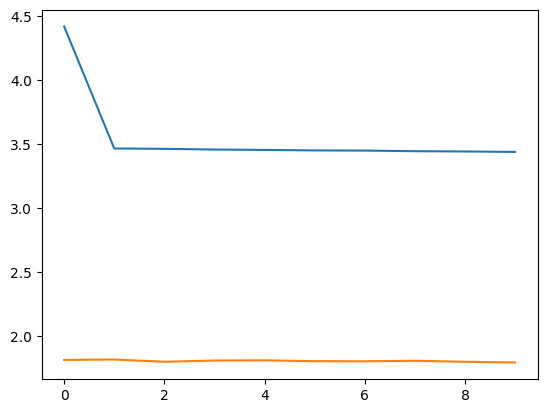

In [ ]:
trnloss = H.history['loss']
tstloss = H.history['val_loss']
plt.plot(trnloss)
plt.plot(tstloss)
plt.show()

In [ ]:
nepochs = 10 #Number of training epochs
bsize = 32    #Batch size
lrate = .001 #Learning rate
lossfunction = 'binary_crossentropy'
wtrange = 1.0  #Range for initial weight randomization

#Define parameters for initial random weights:
wt_init = tf.keras.initializers.RandomUniform(minval = -wtrange, maxval = wtrange, seed = 1111)

#Set parameters for the gradient descent method:
opt = tf.keras.optimizers.Adam(learning_rate=lrate)
input_shape = xtrn.shape[1]  # Feature size of embeddings
output_units = 6  # Corresponds to the number of emotions


# Build the model using the functional API
xin = Input(shape=(input_shape,), name='input_layer')
xhid1 = Dense(128, activation='relu', name='hidden_layer1',
              kernel_initializer=wt_init, bias_initializer=wt_init)(xin)
xdrop1 = Dropout(0.5)(xhid1)
xhid2 = Dense(64, activation='relu', name='hidden_layer2',
              kernel_initializer=wt_init, bias_initializer=wt_init)(xdrop1)
xdrop2 = Dropout(0.5)(xhid2)
xout = Dense(output_units, activation='sigmoid', name='output_layer',
             kernel_initializer=wt_init, bias_initializer=wt_init)(xdrop2)

# Create the model
model = Model(inputs=xin, outputs=xout, name='emotion_model')

# Print the model summary
model.compile(optimizer=opt, loss=lossfunction, metrics=[Accuracy(name='accuracy')])

# Model summary
model.summary()

 #Using the generator for training
train_generator = DataGenerator(xtrn, ytrn, batch_size=bsize)
val_generator = DataGenerator(xtst, ytst, batch_size=bsize)

# Train the model with class weights
H = model.fit(x=train_generator, epochs=nepochs, validation_data=val_generator, class_weight=class_weights)

Model: "emotion_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1536)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 128)               196736    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 hidden_layer2 (Dense)       (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 output_layer (Dense)        (None, 6)                 390       
                                                                 
Total params: 205382 (802.27 KB)
Trainable params: 20

In [ ]:
model.evaluate(x=xtst, y=ytst, batch_size = 100)

417/417 [==============================] - 2s 3ms/step - loss: 0.4545 - accuracy: 0.0000e+00


[0.45449113845825195, 0.0]

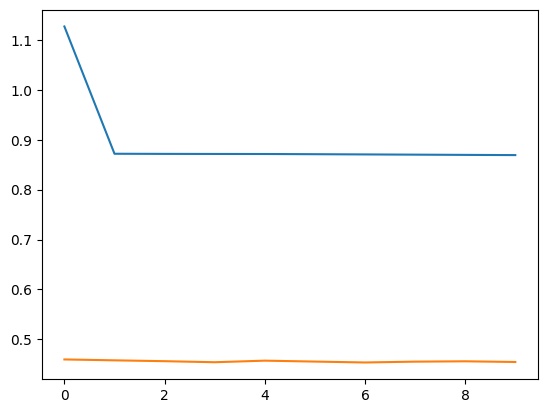

In [ ]:
trnloss = H.history['loss']
tstloss = H.history['val_loss']
plt.plot(trnloss)
plt.plot(tstloss)
plt.show()

Model without dropout

In [ ]:
nepochs = 10 #Number of training epochs
bsize = 32    #Batch size
lrate = .001 #Learning rate
lossfunction = 'binary_crossentropy'
wtrange = 1.0  #Range for initial weight randomization

#Define parameters for initial random weights:
wt_init = tf.keras.initializers.RandomUniform(minval = -wtrange, maxval = wtrange, seed = 1111)

#Set parameters for the gradient descent method:
opt = tf.keras.optimizers.Adam(learning_rate=lrate)
input_shape = xtrn.shape[1]  # Feature size of embeddings
output_units = 6  # Corresponds to the number of emotions


# Build the model using the functional API
xin = Input(shape=(input_shape,), name='input_layer')
xhid1 = Dense(128, activation='relu', name='hidden_layer1',
              kernel_initializer=wt_init, bias_initializer=wt_init)(xin)
xhid2 = Dense(64, activation='relu', name='hidden_layer2',
              kernel_initializer=wt_init, bias_initializer=wt_init)(xhid1)
xout = Dense(output_units, activation='softmax', name='output_layer',
             kernel_initializer=wt_init, bias_initializer=wt_init)(xhid2)

# Create the model
model = Model(inputs=xin, outputs=xout, name='emotion_model')

model.compile(optimizer=opt, loss=lossfunction, metrics=[Accuracy(name='accuracy')])

# Model summary
model.summary()


# Data generators

train_generator = DataGenerator(xtrn, ytrn, batch_size=bsize)
val_generator = DataGenerator(xtst, ytst, batch_size=bsize)
#model.load_weights('ff_initial.h1')

# Training the model
H = model.fit(x=train_generator, epochs=nepochs, validation_data=val_generator, class_weight=class_weights)

In [ ]:
nepochs = 50 #Number of training epochs
bsize = 16    #Batch size
lrate = .001 #Learning rate
lossfunction = 'categorical_crossentropy'
wtrange = 1.0  #Range for initial weight randomization

#Define parameters for initial random weights:
wt_init = tf.keras.initializers.RandomUniform(minval = -wtrange, maxval = wtrange, seed = 1111)

#Set parameters for the gradient descent method:
opt = tf.keras.optimizers.Adam(learning_rate=lrate)
input_shape = xtrn.shape[1]  # Feature size of embeddings
output_units = 6  # Corresponds to the number of emotions


# Build the model using the functional API
xin = Input(shape=(input_shape,), name='input_layer')
xhid1 = Dense(128, activation='relu', name='hidden_layer1',
              kernel_initializer=wt_init, bias_initializer=wt_init)(xin)
xout = Dense(output_units, activation='softmax', name='output_layer',
             kernel_initializer=wt_init, bias_initializer=wt_init)(xhid1)

# Create the model
model = Model(inputs=xin, outputs=xout, name='emotion_model')

model.compile(optimizer=opt, loss=lossfunction, metrics=[CategoricalAccuracy(name='accuracy'),
        Precision(name='precision')])

# Model summary
model.summary()


# Data generators

train_generator = DataGenerator(xtrn, ytrn, batch_size=bsize)
val_generator = DataGenerator(xtst, ytst, batch_size=bsize)


# Training the model
H = model.fit(x=train_generator, epochs=nepochs, validation_data=val_generator, class_weight=class_weights)

Model: "emotion_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1536)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 128)               196736    
                                                                 
 output_layer (Dense)        (None, 6)                 774       
                                                                 
Total params: 197510 (771.52 KB)
Trainable params: 197510 (771.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


AttributeError: module 'sklearn.utils.class_weight' has no attribute 'keys'

Dropout again, batch size changed to 16. Looks promising

In [ ]:
nepochs = 50 #Number of training epochs
bsize = 16    #Batch size
lrate = .001 #Learning rate
lossfunction = 'categorical_crossentropy'
wtrange = 1.0  #Range for initial weight randomization

#Define parameters for initial random weights:
wt_init = tf.keras.initializers.RandomUniform(minval = -wtrange, maxval = wtrange, seed = 1111)

#Set parameters for the gradient descent method:
opt = tf.keras.optimizers.Adam(learning_rate=lrate)
input_shape = xtrn.shape[1]  # Feature size of embeddings
output_units = 6  # Corresponds to the number of emotions


# Build the model using the functional API
xin = Input(shape=(input_shape,), name='input_layer')
xhid1 = Dense(128, activation='relu', name='hidden_layer1',
              kernel_initializer=wt_init, bias_initializer=wt_init)(xin)
xdrop1 = Dropout(0.5)(xhid1)
xhid2 = Dense(64, activation='relu', name='hidden_layer2',
              kernel_initializer=wt_init, bias_initializer=wt_init)(xdrop1)
xdrop2 = Dropout(0.5)(xhid2)
xout = Dense(output_units, activation='softmax', name='output_layer',
             kernel_initializer=wt_init, bias_initializer=wt_init)(xdrop2)

# Create the model
model = Model(inputs=xin, outputs=xout, name='emotion_model')

model.compile(optimizer=opt, loss=lossfunction, metrics=[CategoricalAccuracy(name='accuracy'),
        Precision(name='precision')])

# Model summary
model.summary()


# Data generators

train_generator = DataGenerator(xtrn, ytrn, batch_size=bsize)
val_generator = DataGenerator(xtst, ytst, batch_size=bsize)
model.load_weights('ff_initial.h1')

# Training the model
H = model.fit(x=train_generator, epochs=nepochs, validation_data=val_generator, class_weight=class_weights)

Model: "emotion_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1536)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 128)               196736    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 hidden_layer2 (Dense)       (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 output_layer (Dense)        (None, 6)                 390       
                                                                 
Total params: 205382 (802.27 KB)
Trainable params: 20

KeyboardInterrupt: 

Larger learning rate, .01.

In [ ]:
nepochs = 10 #Number of training epochs
bsize = 32    #Batch size
lrate = .01 #Learning rate
lossfunction = 'categorical_crossentropy'
wtrange = 1.0  #Range for initial weight randomization

#Define parameters for initial random weights:
wt_init = tf.keras.initializers.RandomUniform(minval = -wtrange, maxval = wtrange, seed = 1111)

#Set parameters for the gradient descent method:
opt = tf.keras.optimizers.Adam(learning_rate=lrate)
input_shape = xtrn.shape[1]  # Feature size of embeddings
output_units = 6  # Corresponds to the number of emotions


# Build the model using the functional API
xin = Input(shape=(input_shape,), name='input_layer')
xhid1 = Dense(128, activation='relu', name='hidden_layer1',
              kernel_initializer=wt_init, bias_initializer=wt_init)(xin)
xdrop1 = Dropout(0.5)(xhid1)
xhid2 = Dense(64, activation='relu', name='hidden_layer2',
              kernel_initializer=wt_init, bias_initializer=wt_init)(xdrop1)
xdrop2 = Dropout(0.5)(xhid2)
xout = Dense(output_units, activation='softmax', name='output_layer',
             kernel_initializer=wt_init, bias_initializer=wt_init)(xdrop2)

# Create the model
model = Model(inputs=xin, outputs=xout, name='emotion_model')

model.compile(optimizer=opt, loss=lossfunction, metrics=[CategoricalAccuracy(name='accuracy'),
        Precision(name='precision')])

# Model summary
model.summary()


# Data generators

train_generator = DataGenerator(xtrn, ytrn, batch_size=bsize)
val_generator = DataGenerator(xtst, ytst, batch_size=bsize)


# Training the model
H = model.fit(x=train_generator, epochs=nepochs, validation_data=val_generator, class_weight=class_weights)

Model: "emotion_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1536)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 128)               196736    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 hidden_layer2 (Dense)       (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 output_layer (Dense)        (None, 6)                 390       
                                                                 
Total params: 205382 (802.27 KB)
Trainable params: 20

Smaller learning rate

In [ ]:
nepochs = 10 #Number of training epochs
bsize = 32    #Batch size
lrate = .0001 #Learning rate
lossfunction = 'categorical_crossentropy'
wtrange = 1.0  #Range for initial weight randomization

#Define parameters for initial random weights:
wt_init = tf.keras.initializers.RandomUniform(minval = -wtrange, maxval = wtrange, seed = 1111)

#Set parameters for the gradient descent method:
opt = tf.keras.optimizers.Adam(learning_rate=lrate)
input_shape = xtrn.shape[1]  # Feature size of embeddings
output_units = 6  # Corresponds to the number of emotions


# Build the model using the functional API
xin = Input(shape=(input_shape,), name='input_layer')
xhid1 = Dense(128, activation='relu', name='hidden_layer1',
              kernel_initializer=wt_init, bias_initializer=wt_init)(xin)
xdrop1 = Dropout(0.5)(xhid1)
xhid2 = Dense(64, activation='relu', name='hidden_layer2',
              kernel_initializer=wt_init, bias_initializer=wt_init)(xdrop1)
xdrop2 = Dropout(0.5)(xhid2)
xout = Dense(output_units, activation='softmax', name='output_layer',
             kernel_initializer=wt_init, bias_initializer=wt_init)(xdrop2)

# Create the model
model = Model(inputs=xin, outputs=xout, name='emotion_model')

model.compile(optimizer=opt, loss=lossfunction, metrics=[CategoricalAccuracy(name='accuracy'),
        Precision(name='precision')])

# Model summary
model.summary()


# Data generators

train_generator = DataGenerator(xtrn, ytrn, batch_size=bsize)
val_generator = DataGenerator(xtst, ytst, batch_size=bsize)
model.load_weights('ff_initial.h1')

# Training the model
H = model.fit(x=train_generator, epochs=nepochs, validation_data=val_generator, class_weight=class_weights)

Model: "emotion_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1536)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 128)               196736    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 hidden_layer2 (Dense)       (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 output_layer (Dense)        (None, 6)                 390       
                                                                 
Total params: 205382 (802.27 KB)
Trainable params: 20

Smaller learning rate, removed second hidden layer and dropout.

In [ ]:
nepochs = 10 #Number of training epochs
bsize = 32    #Batch size
lrate = .001 #Learning rate
lossfunction = 'categorical_crossentropy'
wtrange = 1.0  #Range for initial weight randomization

#Define parameters for initial random weights:
wt_init = tf.keras.initializers.RandomUniform(minval = -wtrange, maxval = wtrange, seed = 1111)

#Set parameters for the gradient descent method:
opt = tf.keras.optimizers.Adam(learning_rate=lrate)
input_shape = xtrn.shape[1]  # Feature size of embeddings
output_units = 6  # Corresponds to the number of emotions


# Build the model using the functional API
xin = Input(shape=(input_shape,), name='input_layer')
xhid1 = Dense(128, activation='relu', name='hidden_layer1',
              kernel_initializer=wt_init, bias_initializer=wt_init)(xin)
xdrop1 = Dropout(0.5)(xhid1)
xout = Dense(output_units, activation='softmax', name='output_layer',
             kernel_initializer=wt_init, bias_initializer=wt_init)(xdrop1)
model = Model(inputs=xin, outputs=xout, name='emotion_model')
# Compile the model
model.compile(optimizer=opt, loss=lossfunction, metrics=[CategoricalAccuracy(name='accuracy'),
        Precision(name='precision')])

# Model summary
model.summary()


# Data generators

train_generator = DataGenerator(xtrn, ytrn, batch_size=bsize)
val_generator = DataGenerator(xtst, ytst, batch_size=bsize)
#model.load_weights('ff_initial.h1')

# Training the model
H = model.fit(x=train_generator, epochs=nepochs, validation_data=val_generator, class_weight=class_weights)

Model: "emotion_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1536)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 128)               196736    
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 output_layer (Dense)        (None, 6)                 774       
                                                                 
Total params: 197510 (771.52 KB)
Trainable params: 197510 (771.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
11723/11723 [==============================] - 79s 7ms/step - loss: 3.6223 - accuracy: 0.1063 - precision: 0.1644 - val_loss: 1.8126 -

In [ ]:
model.evaluate(xtst, ytst, batch_size = bsize)

1303/1303 [==============================] - 3s 2ms/step - loss: 1.7820 - accuracy: 0.1889 - precision: 0.1735


[1.7820379734039307, 0.18891102075576782, 0.1734693944454193]

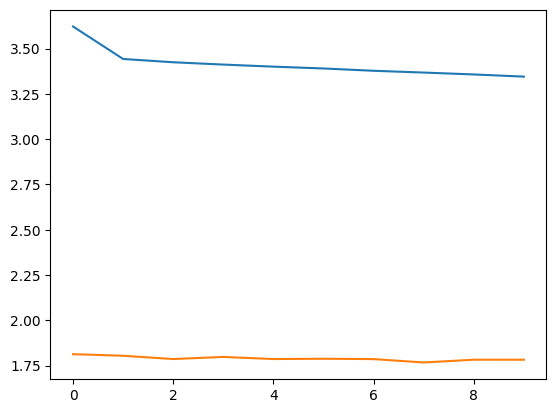

In [ ]:
trnloss = H.history['loss']
tstloss = H.history['val_loss']
plt.plot(trnloss)
plt.plot(tstloss)
plt.show()

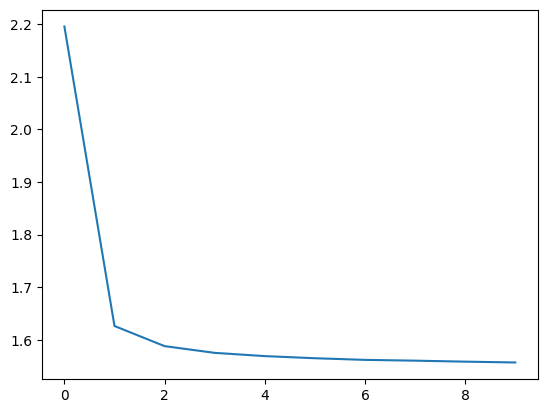

In [ ]:
plt.plot(H.history['loss'], label='Training Loss')

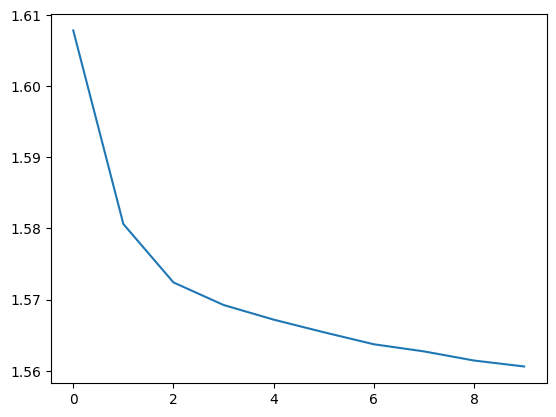

In [ ]:
plt.plot(H.history['val_loss'], label='Validation Loss')

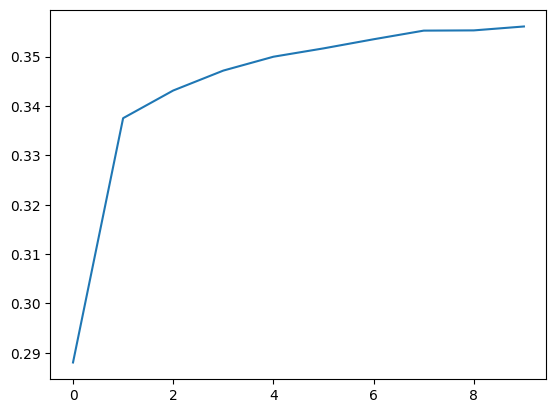

In [ ]:
plt.plot(H.history['accuracy'], label='Training Accuracy')

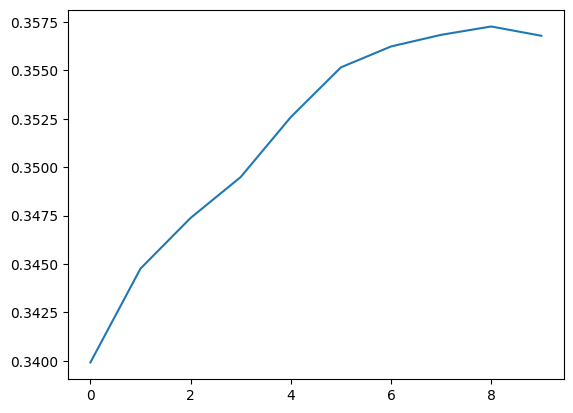

In [ ]:
plt.plot(H.history['val_accuracy'], label='Validation Accuracy')

no second hidden layer, less dense hidden layer

In [ ]:
# Initialize parameters
nepochs = 50
bsize = 32
lrate = 0.001
lossfunction = 'categorical_crossentropy'
wtrange = 1.0
wt_init = tf.keras.initializers.RandomUniform(minval=-wtrange, maxval=wtrange, seed=1111)
opt = tf.keras.optimizers.Adam(learning_rate=lrate)
# Build the model
xin = Input(shape=(input_shape,), name='input_layer')
xhid1 = Dense(64, activation='relu', name='hidden_layer1', kernel_initializer=wt_init)(xin)
xdrop1 = Dropout(0.5)(xhid1)  # Adjusted dropout rate
xout = Dense(output_units, activation='softmax', name='output_layer')(xdrop1)
model = Model(inputs=xin, outputs=xout, name='emotion_model')
# Compile the model
model.compile(optimizer=opt, loss=lossfunction, metrics=[CategoricalAccuracy(name='accuracy'),
        Precision(name='precision')])

# Model summary
model.summary()


# Data generators

train_generator = DataGenerator(xtrn, ytrn, batch_size=bsize)
val_generator = DataGenerator(xtst, ytst, batch_size=bsize)
#model.save_weights('ff_second.h2')

# Training the model
H = model.fit(x=train_generator, epochs=nepochs, validation_data=val_generator, class_weight=class_weights)


Model: "emotion_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1536)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 64)                98368     
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 output_layer (Dense)        (None, 6)                 390       
                                                                 
Total params: 98758 (385.77 KB)
Trainable params: 98758 (385.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
11723/11723 [==============================] - 76s 6ms/step - loss: 3.4440 - accuracy: 0.1736 - precision: 0.2245 - val_loss: 1.7766 - v

In [ ]:
model.evaluate(xtst, ytst, batch_size = bsize)

1303/1303 [==============================] - 4s 3ms/step - loss: 1.7702 - accuracy: 0.2044 - precision: 0.1505


[1.7701972723007202, 0.2043856978416443, 0.15051311254501343]

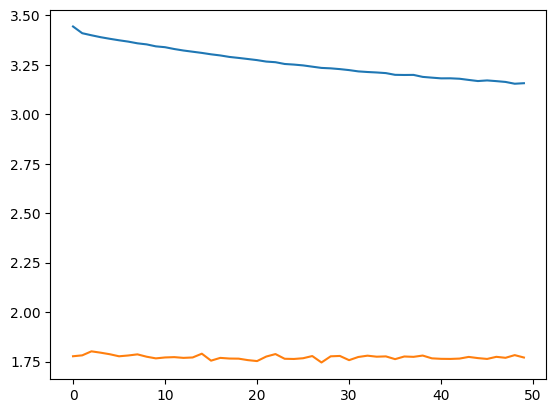

In [ ]:
trnloss = H.history['loss']
tstloss = H.history['val_loss']
plt.plot(trnloss)
plt.plot(tstloss)
plt.show()

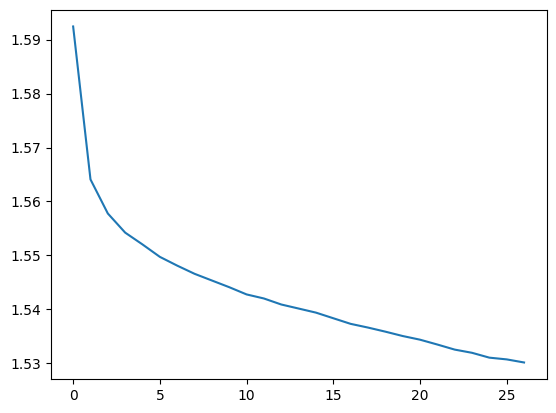

In [ ]:
plt.plot(H.history['loss'], label='Training Loss')

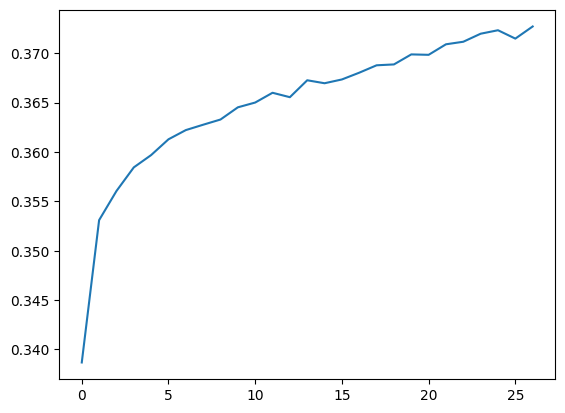

In [ ]:
plt.plot(H.history['accuracy'], label='Training Accuracy')

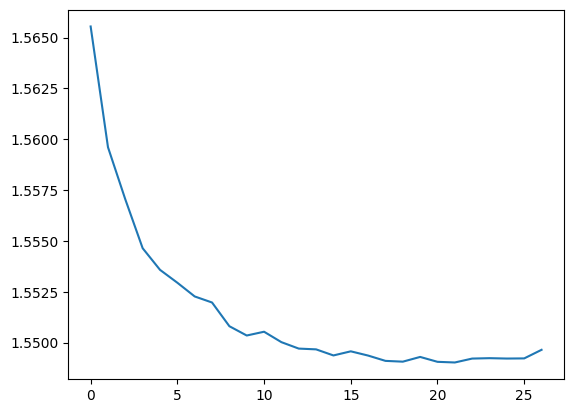

In [ ]:
plt.plot(H.history['val_loss'], label='Validation Loss')

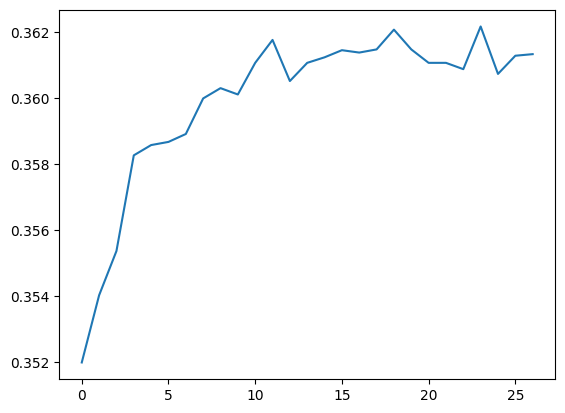

In [ ]:
plt.plot(H.history['val_accuracy'], label='Validation Accuracy')

In [ ]:
# Initialize parameters
input_shape = xtrn.shape[1]  # Feature size of embeddings
output_units = 6  # Corresponds to the number of emotions
nepochs = 50
bsize = 32
lrate = 0.001
lossfunction = 'categorical_crossentropy'
wtrange = 1.0
wt_init = tf.keras.initializers.RandomUniform(minval=-wtrange, maxval=wtrange, seed=1111)
opt = tf.keras.optimizers.Adam(learning_rate=lrate)
# Build the model
xin = Input(shape=(input_shape,), name='input_layer')
xhid1 = Dense(64, activation='relu', name='hidden_layer1', kernel_initializer=wt_init)(xin)
xdrop1 = Dropout(0.3)(xhid1)  # Adjusted dropout rate
xout = Dense(output_units, activation='softmax', name='output_layer')(xdrop1)
model = Model(inputs=xin, outputs=xout, name='emotion_model')

# Compile the model
model.compile(optimizer=opt, loss=lossfunction, metrics=[CategoricalAccuracy(name='accuracy'),
        Precision(name='precision')])

# Model summary
model.summary()


# Data generators

train_generator = DataGenerator(xtrn, ytrn, batch_size=bsize)
val_generator = DataGenerator(xtst, ytst, batch_size=bsize)

# Training the model
H = model.fit(x=train_generator, epochs=nepochs, validation_data=val_generator, class_weight=class_weights)


Model: "emotion_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1536)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 64)                98368     
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 output_layer (Dense)        (None, 6)                 390       
                                                                 
Total params: 98758 (385.77 KB)
Trainable params: 98758 (385.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
11723/11723 [==============================] - 76s 6ms/step - loss: 3.4357 - accuracy: 0.1889 - precision: 0.1929 - val_loss: 1.7677 - v

In [ ]:
model.evaluate(xtst, ytst, batch_size = bsize)

1303/1303 [==============================] - 4s 3ms/step - loss: 1.8192 - accuracy: 0.2036 - precision: 0.1366


[1.8192201852798462, 0.20356997847557068, 0.13655462861061096]

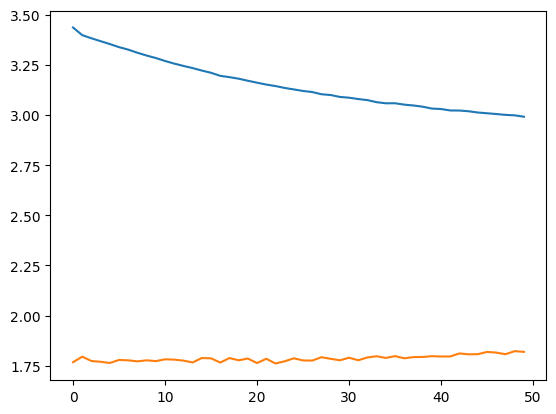

In [ ]:
trnloss = H.history['loss']
tstloss = H.history['val_loss']
plt.plot(trnloss)
plt.plot(tstloss)
plt.show()

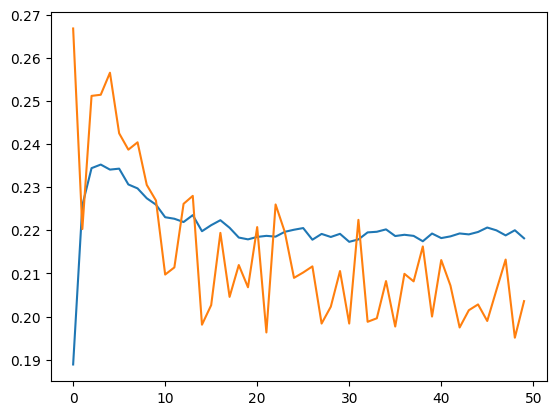

In [ ]:
trnacc = H.history['accuracy']
tstacc = H.history['val_accuracy']
plt.plot(trnacc)
plt.plot(tstacc)
plt.show()

In [ ]:
# Initialize parameters
input_shape = xtrn.shape[1]  # Feature size of embeddings
output_units = 6  # Corresponds to the number of emotions
nepochs = 50
bsize = 32
lrate = 0.001
lossfunction = 'categorical_crossentropy'
wtrange = 1.0
wt_init = tf.keras.initializers.RandomUniform(minval=-wtrange, maxval=wtrange, seed=1111)
opt = tf.keras.optimizers.Adam(learning_rate=lrate)
# Build the model
xin = Input(shape=(input_shape,), name='input_layer')
xhid1 = Dense(128, activation='relu', name='hidden_layer1', kernel_initializer=wt_init)(xin)
xdrop1 = Dropout(0.3)(xhid1)  # Adjusted dropout rate
xout = Dense(output_units, activation='softmax', name='output_layer')(xdrop1)
model = Model(inputs=xin, outputs=xout, name='emotion_model')

# Compile the model
model.compile(optimizer=opt, loss=lossfunction, metrics=[CategoricalAccuracy(name='accuracy'),
        Precision(name='precision')])

# Model summary
model.summary()


# Data generators

train_generator = DataGenerator(xtrn, ytrn, batch_size=bsize)
val_generator = DataGenerator(xtst, ytst, batch_size=bsize)


# Training the model
H = model.fit(x=train_generator, epochs=nepochs, validation_data=val_generator, class_weight=class_weights)

Model: "emotion_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1536)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 128)               196736    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 output_layer (Dense)        (None, 6)                 774       
                                                                 
Total params: 197510 (771.52 KB)
Trainable params: 197510 (771.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
11723/11723 [==============================] - 93s 8ms/step - loss: 3.4299 - accuracy: 0.1877 - precision: 0.1989 - val_loss: 1.7829 -

KeyboardInterrupt: 

In [ ]:
trnloss = H.history['loss']
tstloss = H.history['val_loss']
plt.plot(trnloss)
plt.plot(tstloss)
plt.show()

In [ ]:
# Initialize parameters
input_shape = xtrn.shape[1]  # Feature size of embeddings
output_units = 6
nepochs = 50
bsize = 32
lrate = 0.001
lossfunction = 'categorical_crossentropy'
wtrange = 1.0
wt_init = tf.keras.initializers.RandomUniform(minval=-wtrange, maxval=wtrange, seed=1111)
opt = tf.keras.optimizers.Adam(learning_rate=lrate)
# Build the model
xin = Input(shape=(input_shape,), name='input_layer')
xhid1 = Dense(64, activation='relu', name='hidden_layer1', kernel_initializer=wt_init)(xin)
xdrop1 = Dropout(0.5)(xhid1)  # Adjusted dropout rate
xout = Dense(output_units, name='output_layer')(xdrop1)
model = Model(inputs=xin, outputs=xout, name='emotion_model')
# Compile the model
model.compile(optimizer=opt, loss=lossfunction, metrics=[CategoricalAccuracy(name='accuracy'),
        Precision(name='precision')])

# Model summary
model.summary()


# Data generators

train_generator = DataGenerator(xtrn, ytrn, batch_size=bsize)
val_generator = DataGenerator(xtst, ytst, batch_size=bsize)

# Training the model
H = model.fit(x=train_generator, epochs=nepochs, validation_data=val_generator, class_weight=class_weights)

Model: "emotion_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1536)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 64)                98368     
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 output_layer (Dense)        (None, 6)                 390       
                                                                 
Total params: 98758 (385.77 KB)
Trainable params: 98758 (385.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/50
11723/11723 [==============================] - 82s 7ms/step - loss: 3.9046 - accuracy: 0.1679 - precision: 0.1363 - val_loss: 1.7907 - val_accuracy: 0.1355 - val_precision: 0.0000e+00
Epoch 2/50
11723/11723 [==============================] - 75s 6ms/step - loss: 3.4325 - accuracy: 0.1441 - precision: 0.2500 - val_loss: 1.7856 - val_accuracy: 0.1238 - val_precision: 0.0000e+00
Epoch 3/50
11723/11723 [==============================] - 72s 6ms/step - loss: 3.4092 - accuracy: 0.1325 - precision: 0.0909 - val_loss: 1.7959 - val_accuracy: 0.1332 - val_precision: 0.0000e+00
Epoch 4/50
11723/11723 [==============================] - 71s 6ms/step - loss: 3.3931 - accuracy: 0.1288 - precision: 0.0435 - val_loss: 1.7769 - val_accuracy: 0.1183 - val_precision: 0.0000e+00
Epoch 5/50
11723/11723 [==============================] - 73s 6ms/step - loss: 3.3822 - accuracy: 0.1233 - precision: 0.0328 - val_loss: 1.7780 - val_accuracy: 0.1357 - val_precision: 0.0000e+00
Epoch 6/50
11723/11723 [=

KeyboardInterrupt: 

In [ ]:
model.evaluate(xtst, ytst, batch_size = bsize)

In [ ]:
trnloss = H.history['loss']
tstloss = H.history['val_loss']
plt.plot(trnloss)
plt.plot(tstloss)
plt.show()

In [ ]:
# Initialize parameters
input_shape = xtrn.shape[1]  # Feature size of embeddings
output_units = 6
nepochs = 50
bsize = 16
lrate = 0.001
lossfunction = 'categorical_crossentropy'
wtrange = 1.0
wt_init = tf.keras.initializers.RandomUniform(minval=-wtrange, maxval=wtrange, seed=1111)
opt = tf.keras.optimizers.Adam(learning_rate=lrate)
# Build the model
xin = Input(shape=(input_shape,), name='input_layer')
xhid1 = Dense(64, activation='relu', name='hidden_layer1', kernel_initializer=wt_init)(xin)
xout = Dense(output_units, activation='softmax', name='output_layer')(xhid1)
model = Model(inputs=xin, outputs=xout, name='emotion_model')
# Compile the model
model.compile(optimizer=opt, loss=lossfunction, metrics=[CategoricalAccuracy(name='accuracy'),
        Precision(name='precision')])

# Model summary
model.summary()


# Data generators

train_generator = DataGenerator(xtrn, ytrn, batch_size=bsize)
val_generator = DataGenerator(xtst, ytst, batch_size=bsize)
model.load_weights('ff_initial.h1')

# Training the model
H = model.fit(x=train_generator, epochs=nepochs, validation_data=val_generator, class_weight=class_weight)

Model: "emotion_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1536)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 64)                98368     
                                                                 
 output_layer (Dense)        (None, 6)                 390       
                                                                 
Total params: 98758 (385.77 KB)
Trainable params: 98758 (385.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
23446/23446 [==============================] - 112s 5ms/step - loss: 1.5567 - accuracy: 0.3568 - precision: 0.4379 - recall: 0.0060 - val_loss: 1.5526 - val_accuracy: 0.3611 - val_precision: 0.4470 - val_recall: 0.0014
Epoch 2/50
23446/23446 [=========================

KeyboardInterrupt: 